## Contextual Multi-Armed Bandit for Factorial Experiment
This notebook implements a contextual MAB through thompson sampling with Bayesian linear regression.
Bayesian linear regression assumes mean of the weights follows a multivariate Gaussian prior,variance of the weights follow an inverse gamma distribution.

Reference: Bayesian linear regression notebook https://colab.research.google.com/drive/14w_KDh7MK-ytWKtnMVQFml8h8V59kcA8#scrollTo=dvakyAuvO5M9 by Hammad

In [12]:
import numpy as np
import pandas as pd
from scipy.stats import invgamma
%matplotlib inline
import matplotlib.pyplot as plt
from numpy.linalg import inv
plt.style.use('seaborn-whitegrid')

np.random.seed(0)

In [28]:
#Base bandit class
class Agent():
    def __init__(self, n_feature, action_space):
        self.action_space = action_space
    
    def pick_actions(self,contexts):
        pass
    
    def update_model(self,x,a,r):
        pass

#random bandit
class RandomBandit(Agent):
    def __init__(self, n_feature, action_space):
        Agent.__init__(self,n_feature, action_space)
        
    def pick_actions(self,contexts):
        actions = {}
        for action in self.action_space:
            actions[action] = np.random.choice(self.action_space[action])
        return actions
    
class Thompson_Sampling_Bayesian_Bandit(Agent):
    def __init__(self, n_feature, action_space):
        Agent.__init__(self,n_feature, action_space)
        #design matrix
        self.X = pd.DataFrame()
        #rewards
        self.R = []
        #mean of coefficients
        self.B = None
        #variance of coefficients
        self.V = None
        
    def pick_actions(self,contexts):
        n_params = self.X.shape[1]
        #priors
        m_pre = np.zeros(n_params)
        V_pre = np.identity(n_params)
        
        outcome = np.array(self.R)
        design = self.X.values
        self.posteriors(outcome,design,m_pre,V_pre, 2, 2)
        
        #random actions
        actions = {}
        for action in self.action_space:
            actions[action] = np.random.choice(self.action_space[action])
        return actions
    
    def update_model(self,contexts,actions,r):
        self.R.append(r)
        row = {}
        row['Bias'] = 1.
        row['C0'] = contexts['C0']
        row['C1'] = contexts['C1']
        row['C0 * A0'] = contexts['C0'] * actions['A0']
        row['C1 * A0'] = contexts['C1'] * actions['A0']
        row['C0 * A1'] = contexts['C0'] * actions['A1']
        row['C1 * A1'] = contexts['C1'] * actions['A1']
        self.X = self.X.append(row,ignore_index=True)
        
    def posteriors(self, y, X, m_pre, V_pre, a1_pre, a2_pre):
        # Data size
        datasize = len(y)
        # X transpose
        Xtranspose = np.matrix.transpose(X)
        # Residuals
        # (y - Xb) and (y - Xb)'
        resid = np.subtract(y, np.dot(X,m_pre))
        resid_trans = np.matrix.transpose(resid)

        # N x N middle term for gamma update
        # (I + XVX')^{-1}
        mid_term = np.linalg.inv(np.add(np.identity(datasize), np.dot(np.dot(X, V_pre),Xtranspose)))

        ## Update coeffecients priors

        # Update mean vector
        # [(V^{-1} + X'X)^{-1}][V^{-1}mu + X'y]
        m_post = np.dot(np.linalg.inv(np.add(np.linalg.inv(V_pre), np.dot(Xtranspose,X))), np.add(np.dot(np.linalg.inv(V_pre), m_pre), np.dot(Xtranspose,y)))

        # Update covariance matrix 
        # (V^{-1} + X'X)^{-1}
        V_post = np.linalg.inv(np.add(np.linalg.inv(V_pre), np.dot(Xtranspose,X)))

        ## Update precesion prior
        # Update gamma parameters
        # a + n/2
        a1_post = a1_pre + datasize/2
        # b + (1/2)(y - Xmu)'(I + XVX')^{-1}(y - Xmu)
        a2_post = a2_pre + (np.dot(np.dot(resid_trans, mid_term), resid))/2
        ## Posterior draws
        # Precesions from inverse gamma
        precesion_draw = invgamma.rvs(a1_post, a2_post, size = 1)
        # Coeffecients from multivariate normal
        #beta_draw = np.random.multivariate_normal(m_post, V_post)
        # Return posterior drawn parameters
        
        self.B = m_post
        self.V = V_post
        
        #return np.append(beta_draw, precesion_draw)
        

   Bias   C0  C0 * A0  C0 * A1   C1  C1 * A0  C1 * A1
0   1.0  1.0      0.0      2.0  3.0      0.0      6.0
1   1.0  0.0      0.0      0.0  0.0      0.0      0.0
2   1.0  3.0      0.0      6.0  4.0      0.0      8.0
3   1.0  3.0      3.0      6.0  2.0      2.0      4.0
4   1.0  0.0      0.0      0.0  0.0      0.0      0.0
[32.23653426 -4.93090428 11.99609086 -9.9953278  10.01238342 -7.95502248
 15.02217435]


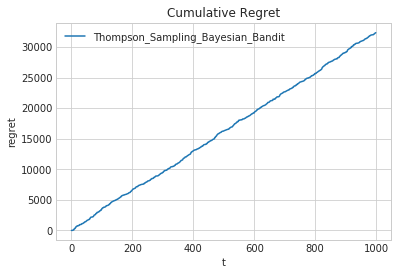

In [32]:
#class that runs simulation and plot regrets
class Experiment():
    def __init__(self, iterations, agent, context_variables, action_space,):
        self.agent = agent
        self.iterations = iterations
        self.context_variables = context_variables
        self.action_space = action_space
        
    def get_true_reward(self, contexts,actions):
        return 30. + (-5.) * contexts['C0'] + 10.0 * contexts['C1'] \
                   + 12. * contexts['C0'] * actions['A0'] + (-8.) * contexts['C1'] * actions['A0'] \
                   + (-10.) * contexts['C0'] * actions['A1'] + 15. * contexts['C1'] * actions['A1'] \
                   + np.random.rand() * 5.
    
    def get_rand_context(self):
        contexts = {}
        for var in self.context_variables:
            contexts[var] = np.random.randint(0,5)
        return contexts
    
    def get_optimal_actions(self,contexts):
        all_possible_a = [{}]
        for cur in self.action_space:
            cur_options = self.action_space[cur]
            new_possible = []
            for a in all_possible_a:
                for cur_a in cur_options:
                    new_a = a.copy()
                    new_a[cur] = cur_a
                    new_possible.append(new_a)
            all_possible_a = new_possible
        return all_possible_a[np.argmax([self.get_true_reward(contexts,a) for a in all_possible_a])]
                  
    def run(self):
        regret = 0.
        regret_list = []
        for i in range(self.iterations):
            contexts = self.get_rand_context()
            actions = self.agent.pick_actions(contexts)
            r = self.get_true_reward(contexts,actions)
            self.agent.update_model(contexts,actions,r)
            regret += abs(r - self.get_true_reward(contexts,self.get_optimal_actions(contexts)))
            regret_list.append(regret)
        
        #plot regrets
        fig,ax = plt.subplots()
        ax.set_title('Cumulative Regret')
        ax.set_xlabel('t')
        ax.set_ylabel('regret')
        #ax.set_ylim(0.,200.)
        ax.plot(regret_list, label=str(type(self.agent).__name__))
        ax.legend()
            
action_space = {'A0':[0,1], 'A1':[0,1,2]}
agent = Thompson_Sampling_Bayesian_Bandit(100,action_space)
exp = Experiment(1000, agent,['C0','C1'],action_space)
exp.run()
print(agent.X.head())
print(agent.B)